<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 10 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 7 April 2022, with material from Peadar Coyle, Gianluca Baio, and Marta Blangiardo</div>

# Bayesian Sports Analytics, in 10 blocks of Science


<br />
<center>
<img src="ipynb.images/fifa22.jpg" width=800 />
</center>

You know what's coming up this summer, right?

Sport analytics can be tougher than F1 because not all teams compete against each other ***at the same time***. The conclusions you draw from Germany beating Sweden depends how strong Sweden is, which in turn depends on the conclusions you draw from Sweden's other games, which in turn depends on how strong Sweden's opponents were, and so this problem is perfect for a **Bayesian model**. 

We want to infer the **latent** (latent means *hidden*) parameters (how strong a team is - that is hidden to us) that are driving the data we observe (scores), and be able to use these to predict ***future*** scores. 

We want to start with some **prior** distributions, and use some observations to refine our priors into **posteriors**. Scores are a noisy measurement of team strength, so quantifying team strength uncertainty is important. It will help us determine where to bet less (games we're weaker at predicting), and games to bet more on (games where uncertainty is minimal).

If you google `Bayesian football`, `Bayesian hierarchical model for the prediction of football results` shows up. Authors Gianluca Baio and Marta Blangiardo model Seria A (Italian) football. Someone used this paper to build a model for rugby, too, but there's a  bug in their code and the model is quite wrong. At the end, they even conclude that there is no correlation between covariates even though pair plots show them to be correlated. Anyway, we are going to use their results and generate a (correct this time) model to put us in a better position to predict future scores. 

This is my version of a Sport Analytics notebook adapted from the rugby notebook by Peadar Coyle and the paper by Baio and Blangiardo, where I apply the theory to the round of 16 of World Cup 2014. Why 2014? 

>In 2014, Greece was in that World Cup! 

I know we've used **normal distributions** throughout our sport models so far, so I wanted to do something different for this notebook!

We will use a Poisson count model to model football game scores!

<div style="text-align: right; color: gray">2</div>

# Regression from a Bayesian perspective (a bit of a review)

Regression from a Bayesian perspective requires us to think ***probabilistically***.

To get the likelihood of our data given our assumptions about how it was generated, we must get the probability of each data point y ***according to the model we pick***, and multiply them all together. Right?

$$\text{data_likelihood} = p(y_1 \;|\; x_1, \theta)*p(y_2 \;|\; x_2, \theta)…*p(y_n \;|\; x_n, \theta)$$

Now w want to find values of $θ$ that maximize this result: Our model is the most probable to yield the data we observe! 

We want the parameters for ***that*** model, *dude*!

But we often work with the `log-likelihood` instead of the `likelihood`, as you saw in your homework, simply because it produces quanitities that do not **underflow** as easily. And because the `log` function is a monotonically increasing function, we know that maximizing the log of a value, with respect to some parameter, coincides with maximizing the value itself. `PyMC3` works with the log likelihood.

Now we use Bayes:

$$p(h \;|\; e) = \dfrac{p(e \;|\; h) * p(h)}{p(e)}$$

where $h$ is the hypothesis (our model parameters) and $e$ the evidence. You start with a prior belief about the hypothesis $p(h)$, then you gather evidence $p(e \;|\; h)$ assuming certain model parameters, and that yields a posterior belief.

$$\text{posterior} = \dfrac{\text{likelihood * prior}}{\text{marginal likelihood}}$$

The denominator exhausts all possibilities with respect to hypothesis $h$, so event $h$ has been *marginalized out*. That is why $p(e)$ is also referred to as the **marginal likelihood**. It's the tough cookie to crack (the Metropolis algorithm gets rid of it in a smart way).

Bayesian methods are **explicit** about uncertainty. They work with probability distritions, not point estimates!

A hypothesis about parameters in a T-test are point estimates, but in Bayesian inference, hypotheses about parameters are distributed with a certain mean and some standard deviation (both of which get updated the more evidence you gather). So your prior is a distribution and your posterior is a distribution, and now you can naturally talk about confidence intervals as a function of the standard deviation, instead of artificially as with the T-test.

We use MCMC methods to come up with the posterior distribution. And once we have our posterior, we are ready to predict. 

<br />
<center>
<img src="ipynb.images/crystall-ball.jpg" width=600 />
</center>

In [39]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

## The data

So I surfed the Web for a few hours for good data. Just for you! And I found a number of interesting Web sites:

* https://github.com/openfootball
* https://github.com/openfootball/world-cup
* Brazil 14 World Cup statistics such as time of posession, number of passes, attacking and defending parameters, etc: https://www.fifa.com/worldcup/archive/brazil2014/statistics/index.html
* Player data for Brazil 14 world cup: https://old.datahub.io/dataset/fifa-world-cup-2014-all-players
* Data for 2018 Kaggle competition: https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset
* https://www.fifa.com/worldcup/archive/brazil2014/matches/index.html

But i just wanted a csv file with just scores. So I stumbled upon a file called `brazil14_scores.csv`, which is what i wanted. I forget from where, but i uploaded it to blackboard :-)

I copied it to my C:\Users\Dino\data folder, I injected it into a pandas data frame, and started poking around.

In [40]:
try:
    df_all = pd.read_csv('./data/brazil14_scores.csv')
except:
    df_all = pd.read_csv(pm.get_data('./data/brazil14_scores.csv'))

In [41]:
df_all

,match_number,location,created_at,status,home_team/country,home_team/code,home_team/goals,away_team/country,away_team/code,away_team/goals,winner,winner_code,home_team/penalties,away_team/penalties
0,1,Arena de Sao Paulo,1402603200000,completed,Brazil,BRA,3,Croatia,CRO,1,Brazil,BRA,NaN,NaN
1,2,Estadio das Dunas,1402675200000,completed,Mexico,MEX,1,Cameroon,CMR,0,Mexico,MEX,NaN,NaN
2,3,Arena Fonte Nova,1402686000000,completed,Spain,ESP,1,Netherlands,NED,5,Netherlands,NED,NaN,NaN
3,4,Arena Pantanal,1402696800000,completed,Chile,CHI,3,Australia,AUS,1,Chile,CHI,NaN,NaN
4,5,Estadio Mineirao,1402761600000,completed,Colombia,COL,3,Greece,GRE,0,Colombia,COL,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,Estadio Nacional,1404576000000,completed,Argentina,ARG,1,Belgium,BEL,0,Argentina,ARG,NaN,NaN
60,61,Estadio Mineirao,1404849600000,completed,Brazil,BRA,1,Germany,GER,7,Germany,GER,NaN,NaN
61,62,Arena de Sao Paulo,1404936000000,completed,Netherlands,NED,0,Argentina,ARG,0,Argentina,ARG,2.0,4.0
62,63,Estadio Nacional,1405195200000,completed,Brazil,BRA,0,Netherlands,NED,3,Netherlands,NED,NaN,NaN


Let's compile a results table:

Specifically, `df_all['game']` = `df_all['home_team/country'] + ' - ' + df_all['away_team/country']`, and `df_all['difference']` = `df_all['home_team/goals'] - df_all['away_team/goals']`

In [42]:
df_all['game'], df_all['difference'] = df_all['home_team/country'] + ' - ' + df_all['away_team/country'], df_all['home_team/goals'] - df_all['away_team/goals']
df_all['games'] = list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference']))
df_all['games']

0            (Brazil - Croatia, 3, 1, 2)
1           (Mexico - Cameroon, 1, 0, 1)
2        (Spain - Netherlands, 1, 5, -4)
3           (Chile - Australia, 3, 1, 2)
4           (Colombia - Greece, 3, 0, 3)
                     ...                
59        (Argentina - Belgium, 1, 0, 1)
60          (Brazil - Germany, 1, 7, -6)
61    (Netherlands - Argentina, 0, 0, 0)
62      (Brazil - Netherlands, 0, 3, -3)
63        (Germany - Argentina, 1, 0, 1)
Name: games, Length: 64, dtype: object

<div style="text-align: right; color: gray">3</div>

# Data exploration

Let's look at a few examples. Germany is always a strong team.

In [43]:
[game for game in list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference'])) if "Germany" in game[0]]

[('Germany - Portugal', 4, 0, 4),
 ('Germany - Ghana', 2, 2, 0),
 ('USA - Germany', 0, 1, -1),
 ('Germany - Algeria', 2, 1, 1),
 ('France - Germany', 0, 1, -1),
 ('Brazil - Germany', 1, 7, -6),
 ('Germany - Argentina', 1, 0, 1)]

And so is Spain:

In [44]:
[game for game in list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference'])) if "Spain" in game[0]]

[('Spain - Netherlands', 1, 5, -4),
 ('Spain - Chile', 0, 2, -2),
 ('Australia - Spain', 0, 3, -3)]

<div style="text-align: right; color: gray">4</div>

# Model based on point differentials

We use pandas' `groupby` API to get match counts, goal sums, and goal standard deviations.

So, for example, `df_all.groupby('home_team/country')` groups all home team games per country, and aggregates by summing the `['difference']` score. If positive, it shows that most of the time, the country playing as a home team scores more goals than it receives.

In [45]:
df_away_count = df_all.groupby('away_team/country')['difference'].count()
df_home_count = df_all.groupby('home_team/country')['difference'].count()
df_away_diff = df_all.groupby('away_team/country')['difference'].sum()
df_home_diff = df_all.groupby('home_team/country')['difference'].sum()
df_away_var = df_all.groupby('away_team/country')['difference'].var()
df_home_var = df_all.groupby('home_team/country')['difference'].var()

# for example
df_home_diff

home_team/country
Algeria                   0
Argentina                 4
Australia                -4
Belgium                   3
Bosnia and Herzegovina    2
Brazil                   -6
Cameroon                 -7
Chile                     2
Colombia                  6
Costa Rica                0
Croatia                  -2
Ecuador                   0
England                  -1
France                    4
Germany                   6
Ghana                    -1
Greece                    1
Honduras                 -4
Iran                      0
Italy                    -2
Ivory Coast               1
Japan                    -3
Korea Republic           -3
Mexico                    1
Netherlands               3
Nigeria                   0
Portugal                  1
Russia                    0
Spain                    -6
Switzerland              -2
USA                      -1
Uruguay                  -1
Name: difference, dtype: int64

Isn't it shocking that many teams score against Brazil, in Brazil?!

Now, the distribution of a sum of two normally distributed independent variates $X$ and $Y$ with means and variances $(μ_X,σ^2_X)$ and $(μ_Y,σ^2_Y)$, respectively is another normal distribution, with mean $μ_{X+Y} = μ_X + μ_Y$ and variance $σ^2_{X+Y} = σ^2_X + σ^2_Y$. You can verify this cool math result just by looking at the formula of a gaussian. 

We are not sure we have normal distributions here, but if we take many games into account, by the Central Limit thoerem, **means** and **standard deviations** are normally distributed.

In [46]:
df_country_mean = (df_home_diff - df_away_diff)/(df_home_count + df_away_count)
df_country_std = np.sqrt(df_home_var.fillna(0) + df_away_var.fillna(0))/(df_home_count + df_away_count)
df_country_mean

home_team/country
Algeria                   0.000000
Argentina                 0.571429
Australia                -2.000000
Belgium                   0.600000
Bosnia and Herzegovina    0.000000
Brazil                   -0.428571
Cameroon                 -2.666667
Chile                     0.500000
Colombia                  1.600000
Costa Rica                0.600000
Croatia                   0.000000
Ecuador                   0.000000
England                  -0.666667
France                    1.400000
Germany                   2.000000
Ghana                    -0.666667
Greece                   -0.500000
Honduras                 -2.333333
Iran                     -1.000000
Italy                    -0.333333
Ivory Coast              -0.333333
Japan                    -1.333333
Korea Republic           -1.000000
Mexico                    0.500000
Netherlands               1.571429
Nigeria                  -0.500000
Portugal                 -1.000000
Russia                   -0.333333
Sp

and plot a picture:

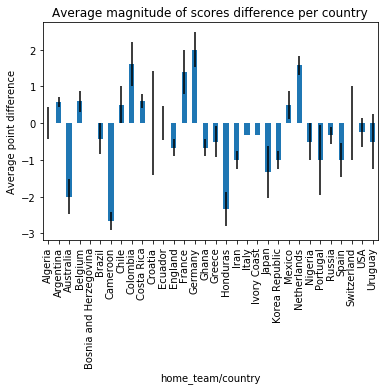

In [47]:
(df_country_mean

      .plot(kind='bar', title='Average magnitude of scores difference per country', yerr=df_country_std)
      .set_ylabel('Average point difference'));

See the good teams emerge?

</br >
<center>
<img src="ipynb.images/droopy-dog.gif" width=100 />
</center>

<div style="text-align: right; color: gray">5</div>

# Building a Bayesian Model

We know that a **count outcome** is modelled as a **Poisson distribution**. 

Modeling team strengths is usually accomplished with a vector of goals scored $y=(y_1,y_2)$ as independent Poisson distributions: $(y_i\;|\;θ_j) \propto Poisson(θ_j)$ where the $\theta_j$ parameters represent the Poisson sole parameter, or scoring intensity, for the team playing at home ($j=1$) and away ($j=2$), respectively.

We will model $\theta$ as an exponential of two independent variables: an attack variable **att**, and a defense variable **def**, times a constant factor k:

$$θ = k * e^{\text{att}_g} * e^{\text{def}_g}$$

>**Note**: Exponential, professor?!! I thought we were building **linear models**...

Yes, we use an exponential to increase the effect of each indendent variable,  but we will use $log(\theta)$ to simplify calculations to a linear model!

>**Ohhhhhh** clever trick, professor!

Since the home team has an advantage over the away team, these parameters are initially modeled with a log-linear random effect model, a standard procedure in sports analytics, and what we saw in class so far (except we take the **log**, and we have **discrete variables** rather than **continuous variables**).

$$\log(θ_1) = \text{home} + log(k) + \text{att}_g + \text{def}_g \\
\log(θ_2) = log(k) + \text{att}_g + \text{def}_g$$

>**Note**: Wait, where's the $x$? There really ***is no $x$***! So we don't really have a linear model, here. Instead, we have an **additive model**!

The parameter `home` (an **intercept** of sorts) represents a **bias**: An advantage for the team hosting the cup, constant for all teams and independent of the score of the game (is that true? Not so sure... the more the team scores, the higher the bias...). 

Let's assume the scoring intensity is determined jointly by an ***attack*** and a ***defense*** ability for each team, an aggregation of the talen tof the attacking players and those of the defensive players + goalkeeper, represented by parameters `att` and `def`, respectively (hmm... shouldn't the goalkeeper count for more?).

For each team $t = 1, \cdots, T$, team-specific attack and defense effects will be modelled by a common normal distribution:
$att_t \propto \text{Normal}(μ_{att},τ_{att})$ and $def_t \propto \text{Normal}(μ_{def}, τ_{def})$.

We will build our model in `PyMC3`, specifying global parameters, team-specific parameters, and the likelihood function.

Ok, so the data we want to consider are the home team and away team goals for each game:

In [48]:
df = df_all[['home_team/country', 'away_team/country', 'home_team/goals', 'away_team/goals']]
df.head()

,home_team/country,away_team/country,home_team/goals,away_team/goals
0,Brazil,Croatia,3,1
1,Mexico,Cameroon,1,0
2,Spain,Netherlands,1,5
3,Chile,Australia,3,1
4,Colombia,Greece,3,0


Let's index the teams:

In [49]:
teams = df['home_team/country'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams

,team,i
0,Brazil,0
1,Mexico,1
2,Spain,2
3,Chile,3
4,Colombia,4
5,Ivory Coast,5
6,Uruguay,6
7,England,7
8,Switzerland,8
9,France,9


Let's tag each game (each row of the spreadsheet) with the index of the home team and that of the away team, and merge our spreadsheet so that each row now represents the combined history of two teams playing each other in designated home/away position:

In [50]:
df = pd.merge(df, teams, left_on='home_team/country', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team/country', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home_team/country,away_team/country,home_team/goals,away_team/goals,i_home,i_away
0,Brazil,Croatia,3,1,0,24
1,Mexico,Cameroon,1,0,1,16
2,Spain,Netherlands,1,5,2,25
3,Chile,Australia,3,1,3,17
4,Colombia,Greece,3,0,4,26


In [51]:
len(df)

64

In [52]:
observed_home_goals = df['home_team/goals'].values
observed_away_goals = df['away_team/goals'].values

home_team = df['i_home'].values
away_team = df['i_away'].values

num_teams = len(teams)
num_games = len(home_team)
num_teams, num_games

(32, 64)

In [53]:
home_team

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
       16,  2, 17,  4, 18,  6, 19,  8, 20, 10, 21, 12, 22, 14, 23, 16, 24,
       17, 25, 18, 26, 19, 27, 20, 28, 21, 29, 22, 30, 23, 31,  0,  4, 25,
       27,  9, 12, 10, 14,  0,  9, 25, 10,  0, 25,  0, 12], dtype=int64)

In [54]:
away_team

array([24, 16, 25, 17, 26, 18, 27, 19, 28, 20, 29, 21, 30, 22, 31, 23,  1,
       24,  3, 25,  5, 26,  7, 27,  9, 28, 11, 29, 13, 30, 15, 31,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  3,  6,  1,
       26, 21, 31,  8, 22,  4, 12, 27, 14, 12, 10, 25, 10], dtype=int64)

In [55]:
observed_home_goals = df['home_team/goals'].values
observed_home_goals

array([3, 1, 1, 3, 3, 2, 1, 1, 2, 3, 2, 0, 4, 1, 2, 1, 0, 0, 0, 2, 2, 0,
       2, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 3,
       0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1],
      dtype=int64)

In [56]:
observed_away_goals = df['away_team/goals'].values
observed_away_goals

array([1, 0, 5, 1, 0, 1, 3, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 4, 2, 3, 1, 0,
       1, 1, 5, 2, 0, 0, 2, 2, 0, 4, 4, 3, 3, 0, 4, 1, 1, 0, 3, 0, 3, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 7, 0, 3, 0],
      dtype=int64)

The number of goals ***received*** at home (scored by the away team) is a good indicator of ***defensive strength*** (the lower number of goals received, the stronger the defense formation).

The number of goals ***scored*** at home (scored by the home team) is a good indicator of ***attacking strength*** (the higher number of goals scored, the stronger the attack formation).

So, these are our priors for the `att` and `def` parameters for each team: We take the mean for all games, and then its logarithm:

In [57]:
g1 = df.groupby('i_away')
att_starting_points = np.log(g1['away_team/goals'].mean())
att_starting_points

i_away
0     1.386294
1     0.287682
2     1.098612
3     0.000000
4     0.916291
5     0.000000
6    -0.693147
7    -0.693147
8     0.405465
9     0.916291
10    0.000000
11   -0.693147
12    1.098612
13    0.405465
14   -0.693147
15   -0.693147
16        -inf
17    0.000000
18    0.000000
19    0.693147
20        -inf
21        -inf
22    0.405465
23    0.000000
24    0.916291
25    1.299283
26   -1.098612
27    0.287682
28    0.405465
29   -0.693147
30    0.000000
31    0.693147
Name: away_team/goals, dtype: float64

In [58]:
g2 = df.groupby('i_home')
def_starting_points = -np.log(g2['home_team/goals'].mean())
def_starting_points
# to replace inf's with zeros:
#list(map(lambda x: 0 if np.isinf(x) else x, def_starting_points))

i_home
0    -0.154151
1    -0.000000
2     0.693147
3    -1.098612
4    -0.847298
5    -0.693147
6    -0.405465
7    -0.000000
8    -0.693147
9    -0.510826
10   -0.223144
11         inf
12   -0.810930
13   -0.000000
14   -0.510826
15   -0.000000
16    0.693147
17   -0.000000
18    0.693147
19         inf
20    0.693147
21   -0.405465
22   -0.000000
23   -0.000000
24   -0.000000
25   -0.000000
26   -0.693147
27    0.693147
28         inf
29   -1.098612
30   -0.693147
31   -0.000000
Name: home_team/goals, dtype: float64

<div style="text-align: right; color: gray">6</div>

Ok, we have our **priors**!

Now let's specity our **likelihood function** in `pymc3`. Note: you might also want to do this with `Sampyl` or [RStan](http://mc-stan.org/users/documentation/case-studies/rstan_workflow.html) (there is a direct port of RStan to Python).

A bit of theory:

You should know that whenever we have a small number of data point (about 30 or less), the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) gives better results than the normal distribution. 

If you are modeling the distribution of a *large* population, then use the **normal distribution**. If you are modeling the mean of the population when the population size is small, better to use the t-distribution, also called the **student-t distribution**.

The student-t distribution has higher kurtosis (4th *moment*) than the normal distribution. That means that data from the t-distribution will have a tendency to appear closer or farther from the mean (it's like your rear-view mirro: ***objects are closer than they appear*** :-):-)) than typical normal data, with a more sudden transition in between. In other words, the t-distribution is more *fat-tailed* and captures outliers ***better***: The probability of obtaining values far from the mean is larger than with the normal distribution.

As the number of degrees of freedom of data increases, the t-distribution becomes closer to the normal distribution. The t-distribution is used a lot in [fintech](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-7701-4_18). Financial data does tend to have higher kurtosis than the normal distribution, and exhibits wild jumps up or down  more frequently than what the normal distribution predicts.

The **half-t distribution** (also denoted **folded-t**) is derived from the t-distribution by taking the absolute values of variates. Since we already know the sign of `att` and `def` parameters, we don't want any negative signs.

Since we decided on a linear model for log$\theta$, we have a *slope-intercept* formula: $y = mx + b$ where $m$ is the slope or the consistent change between $x$ and $y$, and $b$ is the y-intercept (intercepts the y-axis at $y = b$). It is the expected mean value of $y$ when $x = 0$.

So here's the model and likelihood in `pymc3`, starting from the bottom of the cell below, to the top:

- The points scored by the home team and those by the away team, our **data likelihoods**, will be modelled by Poisson distributions. The Poisson distribution has a single parameter: its **Expectation**, which we will model with a **bivariate linear model** with the two features being ***attacking strength*** and ***defensive strength***. However, the home model will also include a **bias** to be added to the **intercept** because the home team always has an advantage over the away team.

- Actually, we will compute with the **log** of the expectation, so to make the log of the expectation a linear model, we will assume that the expectation is actually an **exponential**, with an additive model for the exponent.

- Since attack and defense is a relative concept, we will model these strengths as team-specific strengths minus the average across all teams. Note that we are using an additive relational. We also could have used a multiplicative relation whereby attack and defense is the ratio of team-specific values, normalized by the average across all teams. That's what I would have done, but the italian authors preferred an additive average.

- The team-specific attack and defense strenghts are parameters of our data likelihood, so we need to model them as probability density functions. What to pick? When we don't know, we pick **normal distributions**! How about their mean and standard deviation?

- Bayesian estimation usually assumes a 0 mean for these parameters. For the standard deviation (noise) we will use a half-normal. But to account for many outliers, we will use a **half-student-T** instead (noise is never negative, that's why a **half** profile). The student-T has 3 parameters itself, and here we select numbers: Pure guesses (mean 0, sd of 2.5, and a nu of 3).

- The home bias and the intercept are completely unknown, so we select a **uniform distribution** (all values equally likely)

In [59]:
with pm.Model() as model:
    # global model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # You need to match these to the real priors above - I did not do this because
    # i'm lazy. I just picked a nu and sd out of my hat :-)
    # Note use of student-t because we only have 32 teams, low number.
    home = pm.Flat('home') #flat pdf is uninformative - means we have no idea
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # team-specific model parameters. There is one (atts_star, defs_star) tuple per team.
    # Note use of normal distribution because we assume we have a lot of data per team
    # (not really here, but *you* should!)
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
    # tt is theano.tensor.. why Sampyl may be easier to use..
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])  
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data, Poisson distribution for coutn data, always!
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Cool, right?

Now let's run our sim! 

A *trace* is an MCMC sampling of our posterior probability distribution. It yields the parameters of your model (`att` and `def` per team, for a log-additive model) that are most likely to fit our observations: the team scores. 

We won't specify an algorithm. `Pymc3` will choose `NUTS`.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:32<00:00, 122.89draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


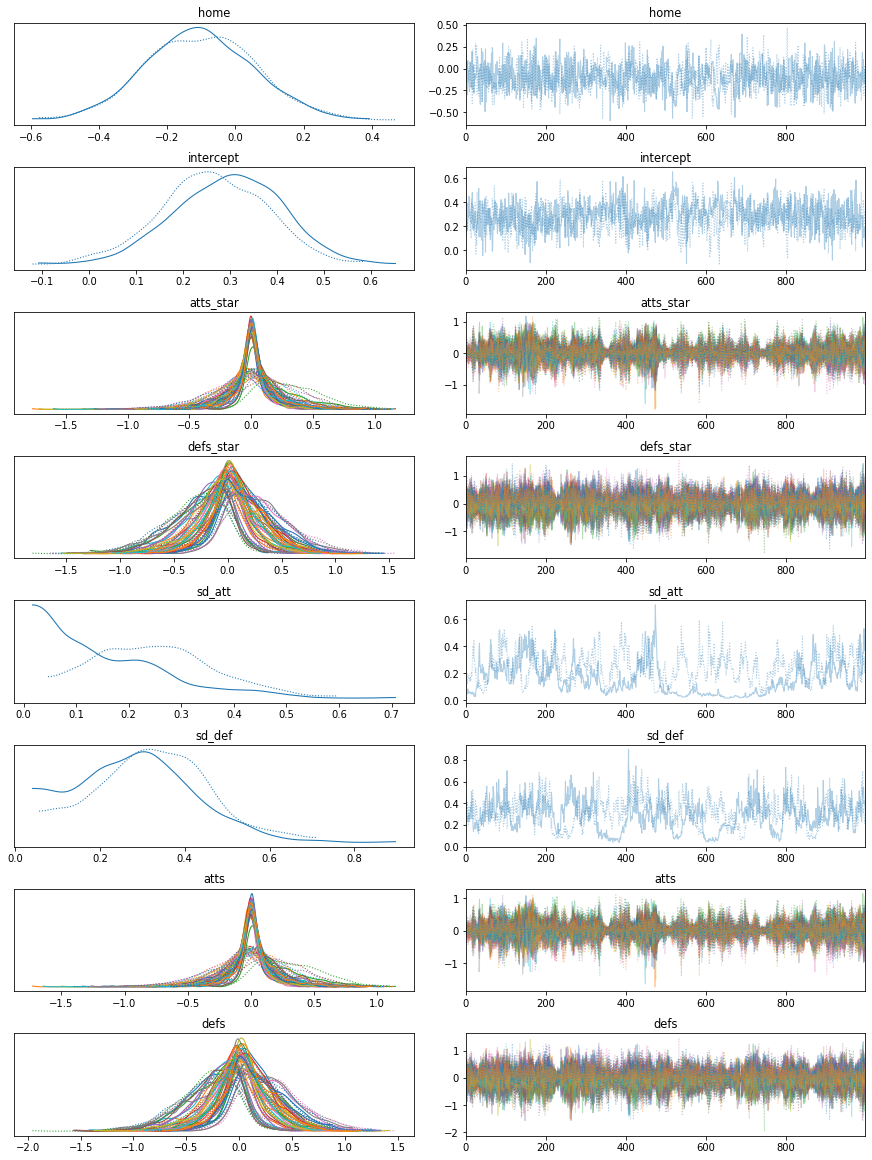

In [60]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)
    pm.traceplot(trace)

<div style="text-align: right; color: gray">7</div>

# Plotting

Let's plot team attacking strengths, with **credible intervals**, so we have uncertainty quantification of our estimate of teams' strengths.

In Bayesian statistics, a **credible interval** is a range of values within which an unobserved parameter value falls with a particular subjective probability. It is an interval in the domain of a posterior probability distribution or a predictive distribution.

Credible intervals are analogous to **confidence intervals** in frequentist statistics we studied when we studied the t-test?

Bayesian intervals treat bounds as *fixed* and the estimated parameter as a *random variable*. In our experiment to determine the distribution of team strength `att`, if the subjective probability that `att`$_{germany}$ lies between 0.35 and 0.55 is 0.95, then $0.35\leq \text{att} \leq 0.55$ is a 95% credible interval.

Frequentist confidence intervals treat bounds as random variables and the parameter as a fixed value. A frequentist 95% confidence interval means that with a large number of repeated samples, 95% of such calculated confidence intervals would include the true value of the parameter. Aren't Bayesian credible intervals a much better metric? I think they are. However, Bayesian credible intervals do require knowledge of a situation-specific prior distribution, while frequentist confidence intervals do not.

The **highest posterior density interval** (HDI) is the interval which contains the required point estimate such that all points within the interval have a higher probability density than points outside the interval. The HDI is the narrowest interval containing the specified point estimate. Locating the HDI is usually accomplished using the Chen-Shao algorithm (Chen and Shao; 1999; Chen, Shao, and Ibrahim; 2000). For more info, this is the best [reference](https://cran.r-project.org/web/packages/HDInterval/HDInterval.pdf) i've found. In `pymc3`, you get it with `stats.hpd`.

**Quantiles** are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The *Median* is an example of a quantile that separates the two halves of a group.

Ok, ready for our model estimates?

In [61]:
trace['atts'].shape

(2000, 32)

In [62]:
pm.stats.hpd(trace['atts'])

d:\Anaconda3.5.1\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
d:\Anaconda3.5.1\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


array([[-0.23723806,  0.51065266],
       [-0.39759245,  0.38634331],
       [-0.3933506 ,  0.4282943 ],
       [-0.41863302,  0.3624396 ],
       [-0.18750955,  0.5962447 ],
       [-0.38632341,  0.42080359],
       [-0.44635181,  0.34694665],
       [-0.50838874,  0.30174431],
       [-0.28428586,  0.50240955],
       [-0.20832564,  0.57353068],
       [-0.36174504,  0.32205258],
       [-0.58121971,  0.29886961],
       [-0.10938696,  0.71949734],
       [-0.40321275,  0.36186607],
       [-0.33392436,  0.38268107],
       [-0.49345803,  0.31332035],
       [-0.65235531,  0.19783293],
       [-0.45291355,  0.35425966],
       [-0.50742066,  0.32122584],
       [-0.55865484,  0.29168462],
       [-0.55740851,  0.29612609],
       [-0.49845961,  0.3010332 ],
       [-0.38497348,  0.38593883],
       [-0.40659833,  0.37899744],
       [-0.33863943,  0.44799532],
       [-0.1439056 ,  0.6145653 ],
       [-0.53790379,  0.26462712],
       [-0.41905788,  0.34147813],
       [-0.46814507,

In [63]:
#pm.stats.quantiles(trace['atts'])

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html
import scipy as sp
sp.stats.mstats.mquantiles(trace['atts'], axis=0)

masked_array(
  data=[[-3.51647365e-02, -1.18848029e-01, -9.34330980e-02,
         -8.53959131e-02,  5.61830179e-03, -8.50189418e-02,
         -1.18602378e-01, -1.67515567e-01, -3.72186519e-02,
         -1.45546193e-02, -1.02240471e-01, -2.15807341e-01,
          4.25451932e-02, -9.06899867e-02, -1.01089405e-01,
         -1.66592029e-01, -2.44004653e-01, -1.17823022e-01,
         -1.79379409e-01, -1.64732869e-01, -2.13824080e-01,
         -1.58202963e-01, -8.75165989e-02, -1.05186712e-01,
         -4.83513554e-02,  4.57402861e-03, -1.74174583e-01,
         -1.35268883e-01, -1.50770367e-01, -7.52735375e-02,
         -8.32868800e-02, -3.30586410e-02],
        [ 3.40711141e-02, -1.74471574e-02, -3.91284717e-03,
          1.97340137e-04,  9.74282242e-02,  5.74716647e-03,
         -1.21740143e-02, -3.88515006e-02,  4.43029948e-02,
          5.91315286e-02, -1.45936916e-03, -6.00887672e-02,
          1.88781229e-01,  3.64918167e-03, -6.76185876e-03,
         -4.03930243e-02, -7.10951735e-02,

A highest posterior density interval is the shortest interval on a posterior density for some given confidence level.

If 1−α is your confidence level (α defaults to 0.05), we can always find two quantiles $q_{1−α/2+c}$, $q_{α/2−c}$ that will give us a working interval. There are a bunch though, and they all have different lengths. We want the shortest:

In [26]:
np.quantile(trace['atts'], 0.5)

-8.013949304092223e-06

In [27]:
pm.stats.hpd(trace['atts'])

array([[-0.24936977,  0.44494779],
       [-0.42331668,  0.35233838],
       [-0.37971468,  0.43367142],
       [-0.35245679,  0.37317398],
       [-0.18586836,  0.59481666],
       [-0.38093736,  0.37914481],
       [-0.42338214,  0.33865513],
       [-0.48981831,  0.31917115],
       [-0.26760303,  0.52123121],
       [-0.21600435,  0.51136778],
       [-0.4133456 ,  0.32813983],
       [-0.58248596,  0.26484216],
       [-0.10245101,  0.72228329],
       [-0.35476832,  0.40308733],
       [-0.36357538,  0.39616185],
       [-0.56126118,  0.31051181],
       [-0.60194729,  0.22844314],
       [-0.38183539,  0.3818046 ],
       [-0.52225325,  0.30136083],
       [-0.50270019,  0.30427019],
       [-0.61226408,  0.29181834],
       [-0.45933718,  0.31398832],
       [-0.42155249,  0.35128953],
       [-0.43117   ,  0.35689848],
       [-0.33478723,  0.45333117],
       [-0.14374785,  0.59303921],
       [-0.50420321,  0.30401714],
       [-0.41248826,  0.31915561],
       [-0.46644678,

In [28]:
[ (a + b)/2 for (a,b) in pm.stats.hpd(trace['atts'])]

[0.09778900999336729,
 -0.03548914856355667,
 0.026978369039063782,
 0.010358595662381814,
 0.2044741507957571,
 -0.0008962770463887548,
 -0.042363506215940566,
 -0.08532358119964512,
 0.12681408910332548,
 0.14768171280290504,
 -0.0426028844371604,
 -0.15882190006187566,
 0.3099161401825756,
 0.024159503689843514,
 0.016293234304378096,
 -0.12537468466887,
 -0.18675207430586796,
 -1.5391728873742627e-05,
 -0.11044621252384834,
 -0.09921500011533343,
 -0.16022287108894898,
 -0.0726744333663171,
 -0.03513147930882496,
 -0.03713576173061825,
 0.05927196910023688,
 0.22464568166094162,
 -0.10009303380215959,
 -0.046666325435918726,
 -0.04990505422145047,
 0.11376218424350115,
 0.02197873471076711,
 0.09579830934052272]

In [29]:
trace['atts'].mean(axis=0)

array([ 0.07879501, -0.03310629,  0.00702981,  0.00450325,  0.15862882,
        0.00672124, -0.02887929, -0.06933708,  0.08131644,  0.10992095,
       -0.01276065, -0.113493  ,  0.2454976 ,  0.00713081, -0.01397241,
       -0.08568165, -0.13082157, -0.03013945, -0.0762545 , -0.0664823 ,
       -0.10495068, -0.06656306,  0.00171214, -0.03154331,  0.04913165,
        0.17204418, -0.08207855, -0.03982211, -0.05213016,  0.02292008,
        0.01131223,  0.08135188])

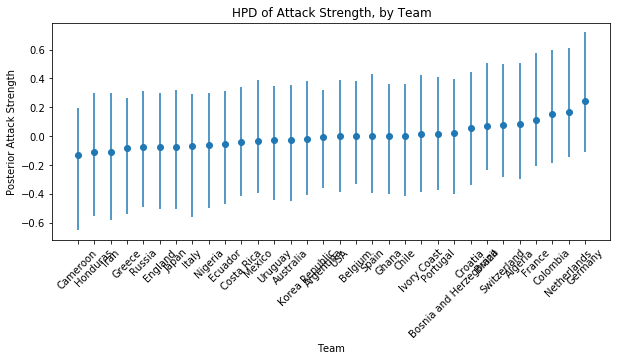

In [64]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
#df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
#                         columns=['hpd_median'],
#                         index=teams.team.values)
#df_median = pd.DataFrame([ (a + b)/2 for (a,b) in pm.stats.hpd(trace['atts'])],
#                         columns=['hpd_median'],
#                         index=teams.team.values)
df_median = pd.DataFrame(trace['atts'].mean(axis=0),
                         columns=['hpd_median'],
                         index=teams.team.values)

df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Greece is well behind Netherlands and Germany in attacking strength.

</br >
<center>
<img src="ipynb.images/sad-dog.png" width=300 />
</center>

However, in defense..

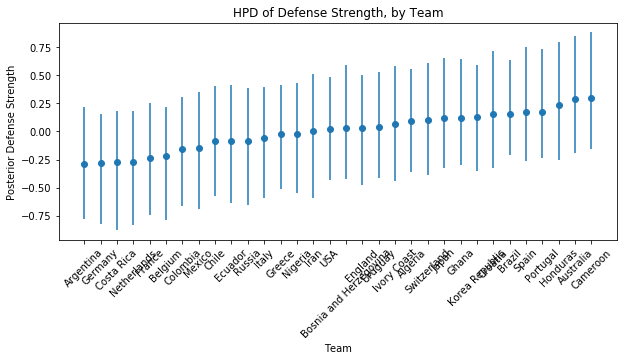

In [65]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
#df_median = pd.DataFrame(pm.stats.quantiles(trace['defs'])[50],
#                         columns=['hpd_median'],
#                         index=teams.team.values)
#df_median = pd.DataFrame([ (a + b)/2 for (a,b) in pm.stats.hpd(trace['defs'])],
#                         columns=['hpd_median'],
#                         index=teams.team.values)
df_median = pd.DataFrame(trace['defs'].mean(axis=0),
                         columns=['hpd_median'],
                         index=teams.team.values)

df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

We expect strong teams to have strong positive effects in attack and strong negative effects in defense. Greece is now in the middle in defense! 

</br >
<center>
<img src="ipynb.images/happy-dog.png" width=300 />
</center>

Here are the 95% highest posterior density intervals for the attack strength for each team.

In [66]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
team,Brazil,Mexico,Spain,Chile,Colombia,Ivory Coast,Uruguay,England,Switzerland,France,...,USA,Korea Republic,Croatia,Netherlands,Greece,Costa Rica,Ecuador,Bosnia and Herzegovina,Portugal,Algeria
i,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


d:\Anaconda3.5.1\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


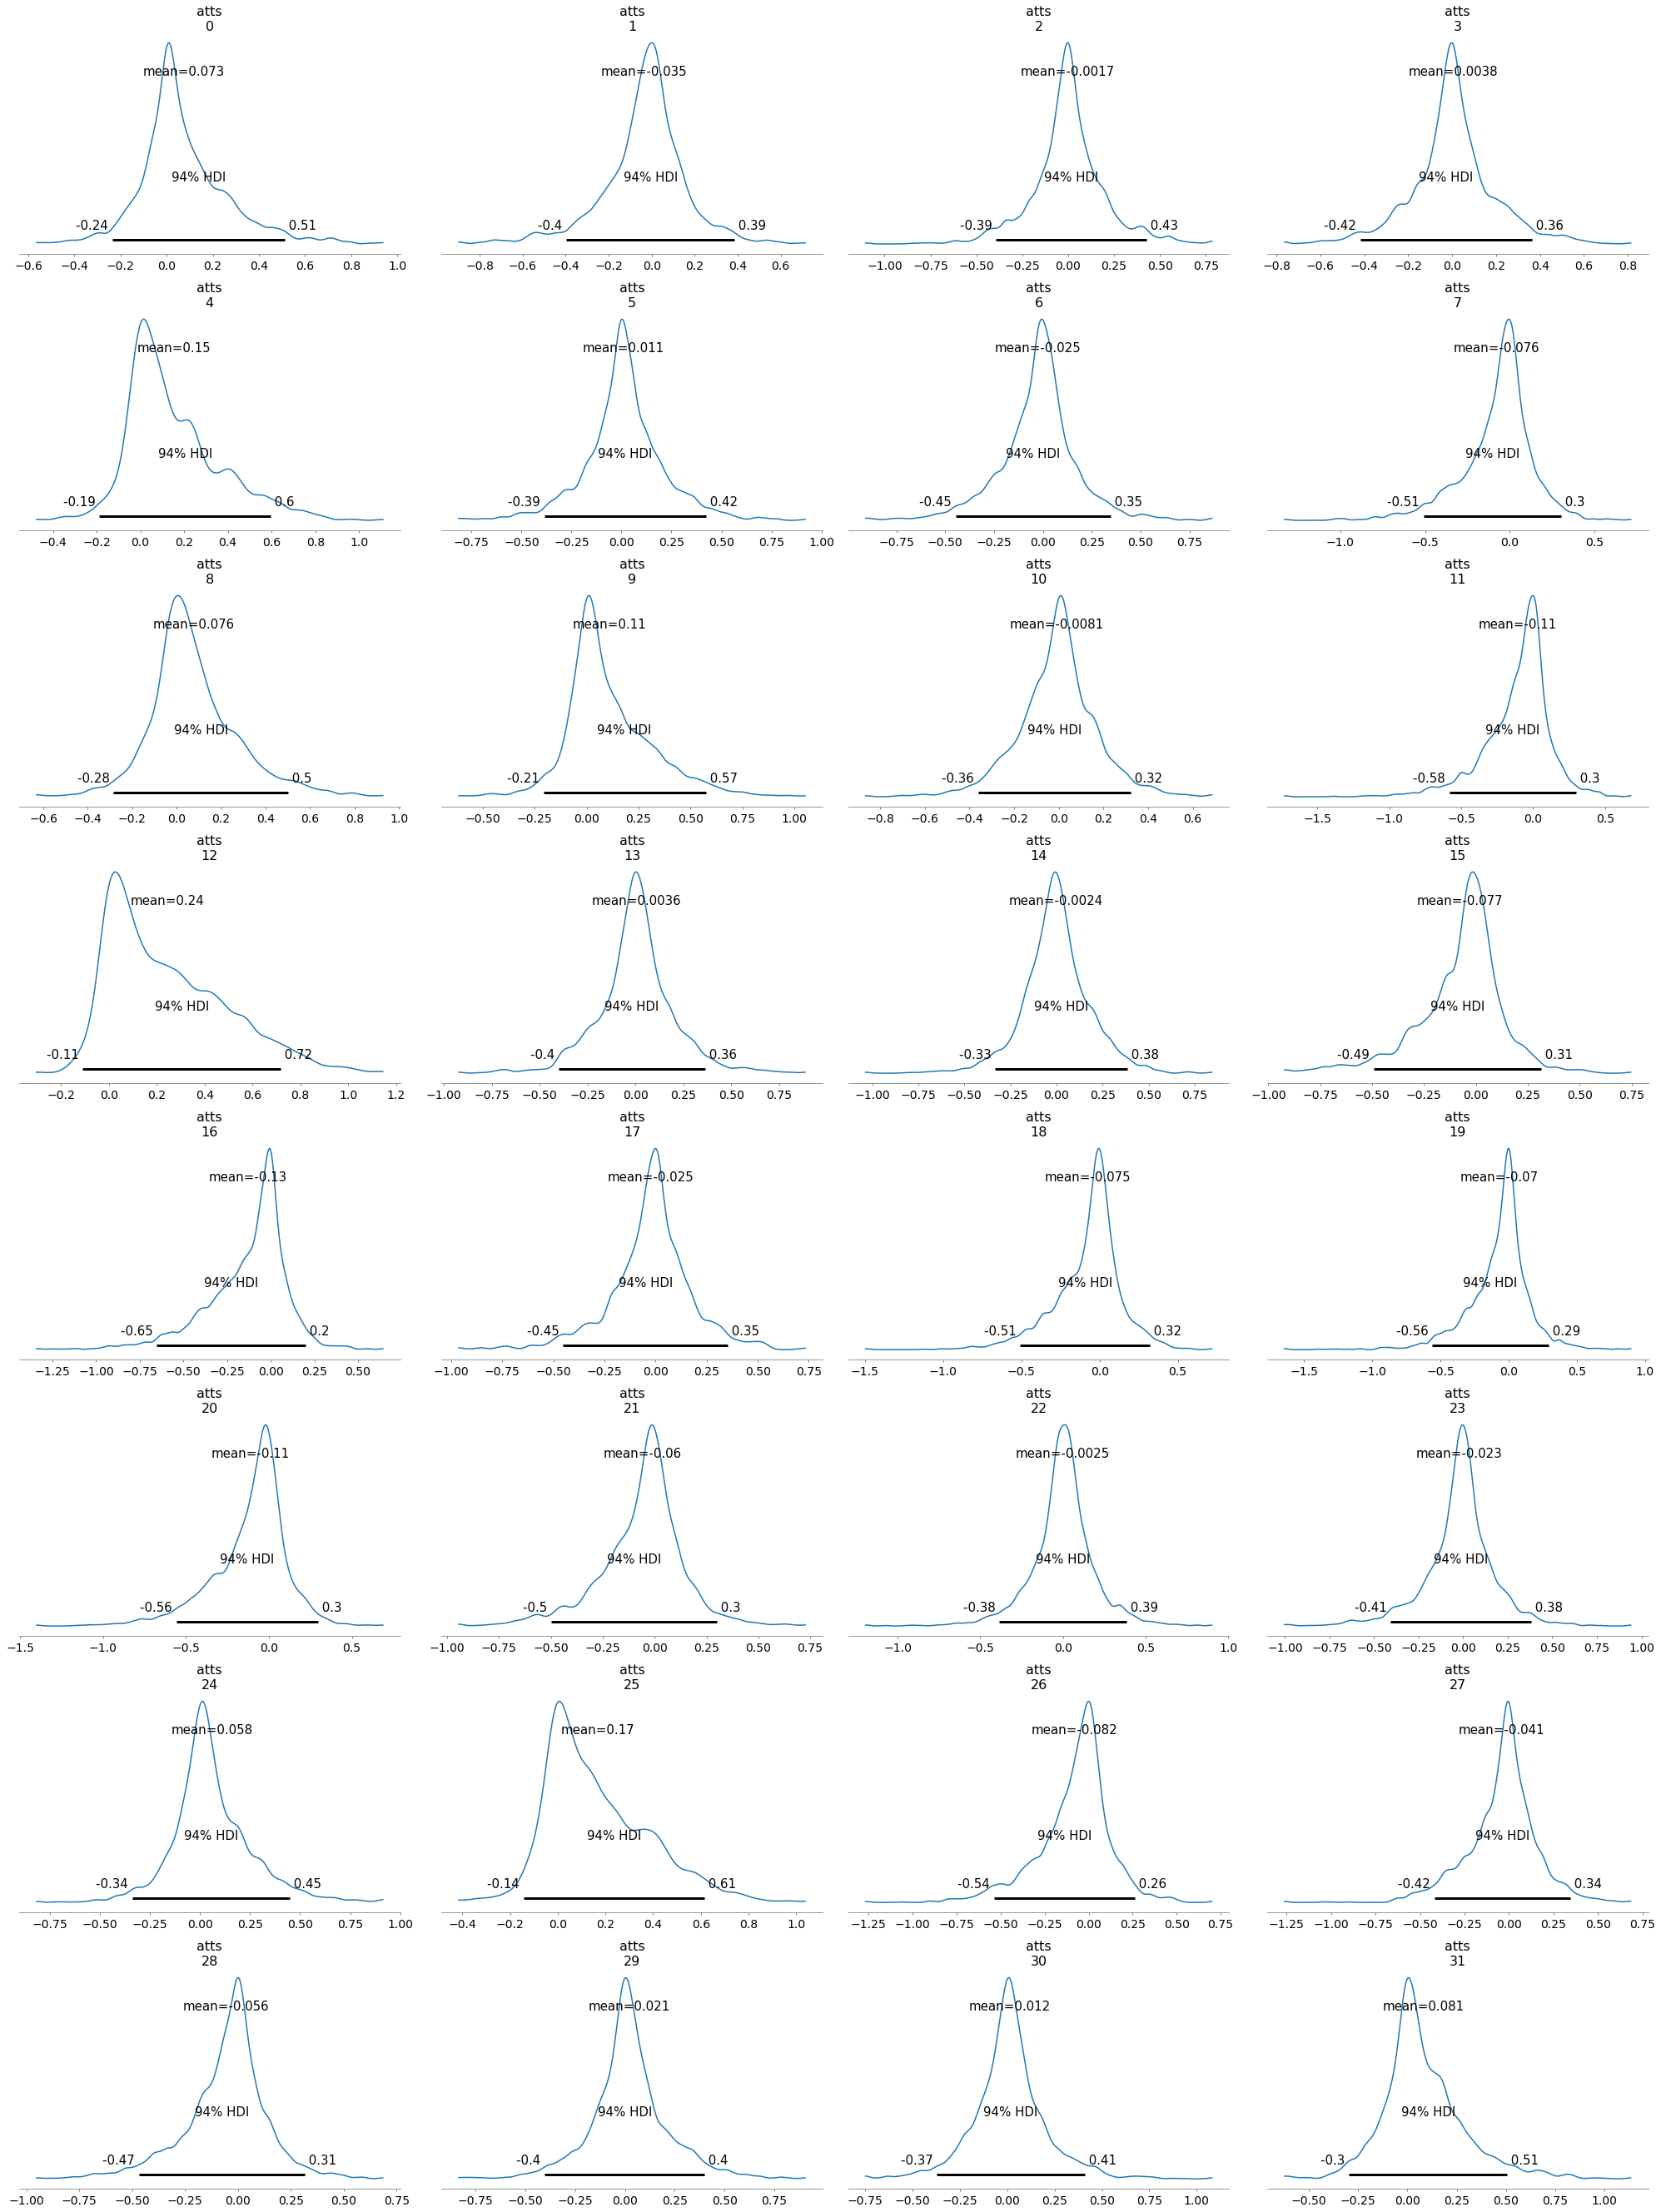

In [67]:
pm.plot_posterior(trace, varnames=['atts']);

Let's compare Germany (#12) and Greece (#26). 

$\mu_{germany}^{att} = 0.3$ while $\mu_{greece}^{att} = -0.103$. 

Germany has a strong positive attacking effect of 0.3, while Greece has a weak *negative* attacking effect of -0.103. This says you expect Germany to score, while you expect Greece not to score.

There are many other priors we could bring into this, such as world ranking, or by player strength, etc.

Now let’s simulate wins over 1000 World Cups!

<div style="text-align: right; color: gray">8</div>

# Validating our model and the future with Posterior Predictive Checks

Comparing the data to the **posterior predictions** of the model is called a **posterior predictive check** (PPC). When there appear to be systematic discrepancies that would be meaningful to address, you should consider expanding or changing the model so it may be a better description of the data.

YOu can read [here](https://www.sciencedirect.com/topics/mathematics/posterior-predictive-check) about Posterior Predictive Checks, and [here](https://www.sciencedirect.com/topics/mathematics/bayesian-model-comparison) about the sensitivity of the Bayes Factor to priors, whenc comparing different models (for example, one model that predicts planetary motions based on elliptical orbits around the sun, as posited by Galileo Galilei, and another that predicts planetary motions based on circular cycles and epicycles around the earth, as posited by the Catholic Church).

Let's do **posterior predictive checks**  in order to validate our model. The idea is to generate data from the model using parameters from draws from the posterior.

PPCs can help analyze the degree to which data generated from the model deviate from data generated from the true distribution. Visualizing the PPC is a great "***sense check***" of your model. In `pymc3`, it's done with `sample_ppc()` of your trace.

Posterior predictive checks are just like a simulation, with the optimal parameters of your model. 

It's like generating new futures from your model, so that you can generates, let's say 100 futures to see what the mean outcome will be.

Let's generate 2,000 World Cups and couny in how many of those futures Greece comes in first!

`ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)` will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random variates from the Poisson distribution specified by the values of the parameters in that sample. If one does not specify the `samples` and `size` parameters, then it will draw one random variate from each trace point, which is what we do here below:

In [68]:
with model:
    pp_trace = pm.sample_ppc(trace)

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 2000/2000 [00:08<00:00, 247.13it/s]


Each World cup is one sample with 64 games. The home team scores goals in each one of those games, as does the away team.

The home team goals are in matrix `pp_trace['home_points']`, and those of the away team are in matrix `pp_trace['away_points']`.

>**Note**: This is not really a fair 2,000 World Cups, since in each one of these World Cups, the ***same exact teams*** play each other. That means that Germany plays 6 games, while Spain and Greece only 3 :-( How could we fix this?

In [77]:
pp_trace

{'home_points': array([[4, 4, 1, ..., 1, 0, 1],
        [3, 3, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 3, 2, ..., 0, 0, 2],
        [1, 4, 1, ..., 0, 3, 1],
        [4, 3, 2, ..., 3, 1, 2]]),
 'away_points': array([[3, 1, 1, ..., 1, 3, 1],
        [1, 2, 2, ..., 1, 1, 2],
        [2, 2, 1, ..., 1, 1, 1],
        ...,
        [3, 0, 0, ..., 2, 1, 1],
        [1, 2, 1, ..., 1, 5, 0],
        [2, 0, 5, ..., 0, 3, 0]])}

In [78]:
pp_trace['home_points'].shape

(2000, 64)

In [79]:
pp_trace['away_points'].shape

(2000, 64)

When `pp_trace['home_points'] > pp_trace['away_points']`, the home team wins. When `pp_trace['home_points'] < pp_trace['away_points']`, it loses.

So, let's see how many times our home teams win and lose from our `pp_trace` simulations, and *artificially score 3 goals for the winning side* (authors do this, not me!):

In [69]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
home_sim_df.insert(0, 'team', df['home_team/country'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
away_sim_df.insert(0, 'team', df['away_team/country'])

In [75]:
pp_trace

{'home_points': array([[4, 4, 1, ..., 1, 0, 1],
        [3, 3, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 3, 2, ..., 0, 0, 2],
        [1, 4, 1, ..., 0, 3, 1],
        [4, 3, 2, ..., 3, 1, 2]]),
 'away_points': array([[3, 1, 1, ..., 1, 3, 1],
        [1, 2, 2, ..., 1, 1, 2],
        [2, 2, 1, ..., 1, 1, 1],
        ...,
        [3, 0, 0, ..., 2, 1, 1],
        [1, 2, 1, ..., 1, 5, 0],
        [2, 0, 5, ..., 0, 3, 0]])}

In [74]:
len((pp_trace['home_points'] < pp_trace['away_points']))

2000

In [72]:
home_sim_df

,team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,...,sim_points_1990,sim_points_1991,sim_points_1992,sim_points_1993,sim_points_1994,sim_points_1995,sim_points_1996,sim_points_1997,sim_points_1998,sim_points_1999
0,Brazil,3,3,0,0,3,0,0,0,0,...,0,0,0,3,0,3,0,0,0,3
1,Mexico,3,3,0,3,0,3,3,0,0,...,0,3,3,0,0,0,3,3,3,3
2,Spain,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
3,Chile,3,3,0,0,0,3,0,3,3,...,3,3,0,0,3,3,0,0,0,0
4,Colombia,3,0,3,0,0,0,0,3,0,...,0,3,0,3,3,0,3,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Argentina,0,3,0,0,0,0,0,0,0,...,0,3,0,3,3,0,3,3,0,0
60,Brazil,0,0,0,0,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,0
61,Netherlands,0,0,3,0,3,0,3,0,3,...,0,3,0,0,0,0,0,0,0,3
62,Brazil,0,0,3,3,0,0,0,0,0,...,0,0,0,0,3,0,3,0,0,0


Let's group results alphabetically in a table that represents the probabilities of coming in 1st, 2nd, 3rd, etc. for each country:

In [70]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [96]:
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0
team,,,,,,,,,,,,,,,,,,,,,
Algeria,0.039,0.068,0.115,0.076,0.108,0.132,0.161,0.101,0.049,0.021,...,0.037,0.054,0.074,0.066,0.066,0.037,0.021,0.009,0.002,0.000
Argentina,0.429,0.323,0.234,0.146,0.132,0.118,0.110,0.072,0.039,0.019,...,0.005,0.012,0.018,0.016,0.012,0.008,0.005,0.003,0.000,0.000
Australia,0.005,0.012,0.024,0.028,0.053,0.072,0.080,0.052,0.031,0.011,...,0.065,0.118,0.150,0.172,0.130,0.093,0.031,0.009,0.002,0.000
Belgium,0.133,0.202,0.185,0.171,0.145,0.154,0.163,0.113,0.058,0.016,...,0.023,0.018,0.028,0.022,0.027,0.014,0.005,0.005,0.000,0.000
Bosnia and Herzegovina,0.011,0.025,0.040,0.061,0.087,0.106,0.148,0.096,0.041,0.018,...,0.039,0.079,0.113,0.095,0.100,0.052,0.023,0.004,0.002,0.000
Brazil,0.228,0.205,0.168,0.145,0.127,0.153,0.155,0.114,0.041,0.013,...,0.010,0.024,0.031,0.024,0.024,0.016,0.010,0.003,0.000,0.000
Cameroon,0.002,0.011,0.020,0.030,0.047,0.069,0.080,0.057,0.024,0.011,...,0.061,0.123,0.157,0.170,0.160,0.088,0.046,0.013,0.001,0.000
Chile,0.070,0.117,0.164,0.135,0.156,0.152,0.158,0.128,0.052,0.025,...,0.020,0.029,0.049,0.033,0.035,0.021,0.009,0.003,0.000,0.000
Colombia,0.219,0.287,0.248,0.180,0.149,0.128,0.148,0.101,0.041,0.011,...,0.006,0.014,0.029,0.009,0.019,0.009,0.005,0.001,0.000,0.000


A graph that represents probabilities of coming in 1st:

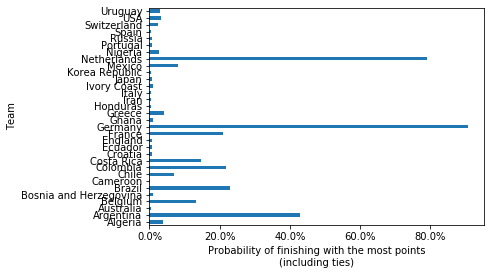

In [71]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n(including ties)");

ax.set_ylabel("Team");

So, Germany, Netherlands, and Argentina it is, according to our Brazil 14 World Cup model! 

According to this model, Germany finishes with the most points about 48% of the time, Netherlands finishes with the most points 38% of the time, and Argentina finishes with the most points about 20% of the time (Greece, about 1% of the time - I want to live in *that* universe!).

That's how the authors tabulated their results!

Can we improve?

Here are some of the problems:

In [102]:
sim_table.loc['Algeria', :]

rank
1.0     0.039
2.0     0.068
3.0     0.115
4.0     0.076
5.0     0.108
6.0     0.132
7.0     0.161
8.0     0.101
9.0     0.049
10.0    0.021
11.0    0.028
12.0    0.063
13.0    0.116
14.0    0.159
15.0    0.141
16.0    0.089
17.0    0.075
18.0    0.042
19.0    0.016
20.0    0.007
21.0    0.008
22.0    0.020
23.0    0.037
24.0    0.054
25.0    0.074
26.0    0.066
27.0    0.066
28.0    0.037
29.0    0.021
30.0    0.009
31.0    0.002
32.0    0.000
Name: Algeria, dtype: float64

In [103]:
sim_table.loc['Algeria', :].values

array([0.039, 0.068, 0.115, 0.076, 0.108, 0.132, 0.161, 0.101, 0.049,
       0.021, 0.028, 0.063, 0.116, 0.159, 0.141, 0.089, 0.075, 0.042,
       0.016, 0.007, 0.008, 0.02 , 0.037, 0.054, 0.074, 0.066, 0.066,
       0.037, 0.021, 0.009, 0.002, 0.   ])

In [104]:
sum(sim_table.loc['Algeria', :].values)

2.0

In [105]:
sum(sim_table.loc['Germany', :].values)

1.9999999999999982

Oh no! Probabilities don't sum up to 1!

`pp_trace['home_points']` are the home team scores for countries in this order:

In [80]:
home_team

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
       16,  2, 17,  4, 18,  6, 19,  8, 20, 10, 21, 12, 22, 14, 23, 16, 24,
       17, 25, 18, 26, 19, 27, 20, 28, 21, 29, 22, 30, 23, 31,  0,  4, 25,
       27,  9, 12, 10, 14,  0,  9, 25, 10,  0, 25,  0, 12], dtype=int64)

`pp_trace['away_points']` are the away team scores for countries in this order:

In [81]:
away_team

array([24, 16, 25, 17, 26, 18, 27, 19, 28, 20, 29, 21, 30, 22, 31, 23,  1,
       24,  3, 25,  5, 26,  7, 27,  9, 28, 11, 29, 13, 30, 15, 31,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  3,  6,  1,
       26, 21, 31,  8, 22,  4, 12, 27, 14, 12, 10, 25, 10], dtype=int64)

Instead of artificially scoring 3 goals for the winning team, let's correctly tabulate the score differential for each game, gathering from both `pp_trace['home_points']` and `pp_trace['home_points']`:

In [85]:
df['away_team/country'].values

array(['Croatia', 'Cameroon', 'Netherlands', 'Australia', 'Greece',
       'Japan', 'Costa Rica', 'Italy', 'Ecuador', 'Honduras',
       'Bosnia and Herzegovina', 'Nigeria', 'Portugal', 'USA', 'Algeria',
       'Korea Republic', 'Mexico', 'Croatia', 'Chile', 'Netherlands',
       'Ivory Coast', 'Greece', 'England', 'Costa Rica', 'France',
       'Ecuador', 'Iran', 'Bosnia and Herzegovina', 'Ghana', 'Portugal',
       'Russia', 'Algeria', 'Brazil', 'Mexico', 'Spain', 'Chile',
       'Colombia', 'Ivory Coast', 'Uruguay', 'England', 'Switzerland',
       'France', 'Argentina', 'Iran', 'Germany', 'Ghana', 'Belgium',
       'Russia', 'Chile', 'Uruguay', 'Mexico', 'Greece', 'Nigeria',
       'Algeria', 'Switzerland', 'USA', 'Colombia', 'Germany',
       'Costa Rica', 'Belgium', 'Germany', 'Argentina', 'Netherlands',
       'Argentina'], dtype=object)

In [84]:
df['home_team/country'].values

array(['Brazil', 'Mexico', 'Spain', 'Chile', 'Colombia', 'Ivory Coast',
       'Uruguay', 'England', 'Switzerland', 'France', 'Argentina', 'Iran',
       'Germany', 'Ghana', 'Belgium', 'Russia', 'Brazil', 'Cameroon',
       'Spain', 'Australia', 'Colombia', 'Japan', 'Uruguay', 'Italy',
       'Switzerland', 'Honduras', 'Argentina', 'Nigeria', 'Germany',
       'USA', 'Belgium', 'Korea Republic', 'Cameroon', 'Croatia',
       'Australia', 'Netherlands', 'Japan', 'Greece', 'Italy',
       'Costa Rica', 'Honduras', 'Ecuador', 'Nigeria',
       'Bosnia and Herzegovina', 'USA', 'Portugal', 'Korea Republic',
       'Algeria', 'Brazil', 'Colombia', 'Netherlands', 'Costa Rica',
       'France', 'Germany', 'Argentina', 'Belgium', 'Brazil', 'France',
       'Netherlands', 'Argentina', 'Brazil', 'Netherlands', 'Brazil',
       'Germany'], dtype=object)

In [87]:
list(zip(df['home_team/country'].values, df['away_team/country'].values))

[('Brazil', 'Croatia'),
 ('Mexico', 'Cameroon'),
 ('Spain', 'Netherlands'),
 ('Chile', 'Australia'),
 ('Colombia', 'Greece'),
 ('Ivory Coast', 'Japan'),
 ('Uruguay', 'Costa Rica'),
 ('England', 'Italy'),
 ('Switzerland', 'Ecuador'),
 ('France', 'Honduras'),
 ('Argentina', 'Bosnia and Herzegovina'),
 ('Iran', 'Nigeria'),
 ('Germany', 'Portugal'),
 ('Ghana', 'USA'),
 ('Belgium', 'Algeria'),
 ('Russia', 'Korea Republic'),
 ('Brazil', 'Mexico'),
 ('Cameroon', 'Croatia'),
 ('Spain', 'Chile'),
 ('Australia', 'Netherlands'),
 ('Colombia', 'Ivory Coast'),
 ('Japan', 'Greece'),
 ('Uruguay', 'England'),
 ('Italy', 'Costa Rica'),
 ('Switzerland', 'France'),
 ('Honduras', 'Ecuador'),
 ('Argentina', 'Iran'),
 ('Nigeria', 'Bosnia and Herzegovina'),
 ('Germany', 'Ghana'),
 ('USA', 'Portugal'),
 ('Belgium', 'Russia'),
 ('Korea Republic', 'Algeria'),
 ('Cameroon', 'Brazil'),
 ('Croatia', 'Mexico'),
 ('Australia', 'Spain'),
 ('Netherlands', 'Chile'),
 ('Japan', 'Colombia'),
 ('Greece', 'Ivory Coast'),
 

In [88]:
sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): h - a
        for i, (h,a) in enumerate(zip(pp_trace['home_points'], pp_trace['away_points']))
})
sim_df.insert(0, 'teams', list(zip(df['home_team/country'].values, df['away_team/country'].values)))

In [89]:
sim_df

,teams,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,...,sim_points_1990,sim_points_1991,sim_points_1992,sim_points_1993,sim_points_1994,sim_points_1995,sim_points_1996,sim_points_1997,sim_points_1998,sim_points_1999
0,"(Brazil, Croatia)",1,2,-2,0,2,-3,-1,-4,-3,...,-1,-1,-2,1,0,2,0,-3,0,2
1,"(Mexico, Cameroon)",3,1,-2,2,0,1,1,0,-2,...,0,2,3,0,-6,0,2,3,2,3
2,"(Spain, Netherlands)",0,-2,-1,0,-3,-4,-3,0,-1,...,-1,-3,0,-4,-1,-3,-2,2,0,-3
3,"(Chile, Australia)",2,2,-2,-1,-1,1,-1,3,2,...,2,3,0,-2,1,1,0,-1,-1,-1
4,"(Colombia, Greece)",5,0,3,0,-1,0,-3,2,0,...,-1,1,0,1,2,-2,5,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"(Argentina, Belgium)",0,1,0,-1,-1,0,0,-1,-4,...,0,1,0,1,1,-1,2,3,0,-1
60,"(Brazil, Germany)",-2,-4,0,-1,-3,-1,0,2,1,...,-2,-2,-1,-6,-1,-2,-2,-1,-4,-2
61,"(Netherlands, Argentina)",0,-1,1,0,1,-1,1,-1,3,...,-1,1,-1,0,-1,-1,-2,-2,-1,3
62,"(Brazil, Netherlands)",-3,0,1,1,0,0,-1,0,-2,...,0,-1,-2,-3,4,-1,1,-1,-2,-2


Now, how do we generate World Cup winners from this table, and from 2,000 games generate frequentist probabilities of winning the World Cup?

In [106]:
sim_df2 = pd.DataFrame({
    'sim_points_{}'.format(i): h - a
        for i, (h,a) in enumerate(zip(pp_trace['home_points'], pp_trace['away_points']))
})
sim_df2.insert(0, 'away-team', df['away_team/country'])
sim_df2.insert(0, 'home-team', df['home_team/country'])

In [107]:
sim_df2

,home-team,away-team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,...,sim_points_1990,sim_points_1991,sim_points_1992,sim_points_1993,sim_points_1994,sim_points_1995,sim_points_1996,sim_points_1997,sim_points_1998,sim_points_1999
0,Brazil,Croatia,1,2,-2,0,2,-3,-1,-4,...,-1,-1,-2,1,0,2,0,-3,0,2
1,Mexico,Cameroon,3,1,-2,2,0,1,1,0,...,0,2,3,0,-6,0,2,3,2,3
2,Spain,Netherlands,0,-2,-1,0,-3,-4,-3,0,...,-1,-3,0,-4,-1,-3,-2,2,0,-3
3,Chile,Australia,2,2,-2,-1,-1,1,-1,3,...,2,3,0,-2,1,1,0,-1,-1,-1
4,Colombia,Greece,5,0,3,0,-1,0,-3,2,...,-1,1,0,1,2,-2,5,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Argentina,Belgium,0,1,0,-1,-1,0,0,-1,...,0,1,0,1,1,-1,2,3,0,-1
60,Brazil,Germany,-2,-4,0,-1,-3,-1,0,2,...,-2,-2,-1,-6,-1,-2,-2,-1,-4,-2
61,Netherlands,Argentina,0,-1,1,0,1,-1,1,-1,...,-1,1,-1,0,-1,-1,-2,-2,-1,3
62,Brazil,Netherlands,-3,0,1,1,0,0,-1,0,...,0,-1,-2,-3,4,-1,1,-1,-2,-2


<div id="theID" style="display: none;">
# Germany's home-team games
sim_df2[sim_df2['home-team'] == 'Germany']
</div>

<div id="theID" style="display: none;">
# Germany's away-team games
sim_df2[sim_df2['away-team'] == 'Germany']
</div>

<div id="theID" style="display: none;">
# Germany's simulated scores against the same teams Germany played in Brazil 14
print(list(filter(lambda x: x > 0, sim_df2[sim_df2['away-team'] == 'Germany'].iloc[0].values[2:])))
print(list(filter(lambda x: x < 0, sim_df2[sim_df2['away-team'] == 'Germany'].iloc[0].values[2:])))
</div>

<div style="text-align: right; color: gray">9</div>

# Covariate exploration

Let's finish with some covariates exploration. The covariates here are the team-specific attack and defense strenth parameters as MCMC-sampled from their posterior distribution. Let's see if we can find correlations between attacking strengths for teams that are dear to my heart. 

We could, hypothetically, find that when Germany is strong, Greece is strong. That won't be the case in all likelihood (unless all greek players play in the Bundesliga). This is probably how you'd try to find patterns in stock market models. For example, gold futures are inversely proportional to bear markets. But we check nonetheless.

In [46]:
df_trace = pm.trace_to_dataframe(trace)

In [47]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
team,Brazil,Mexico,Spain,Chile,Colombia,Ivory Coast,Uruguay,England,Switzerland,France,...,USA,Korea Republic,Croatia,Netherlands,Greece,Costa Rica,Ecuador,Bosnia and Herzegovina,Portugal,Algeria
i,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


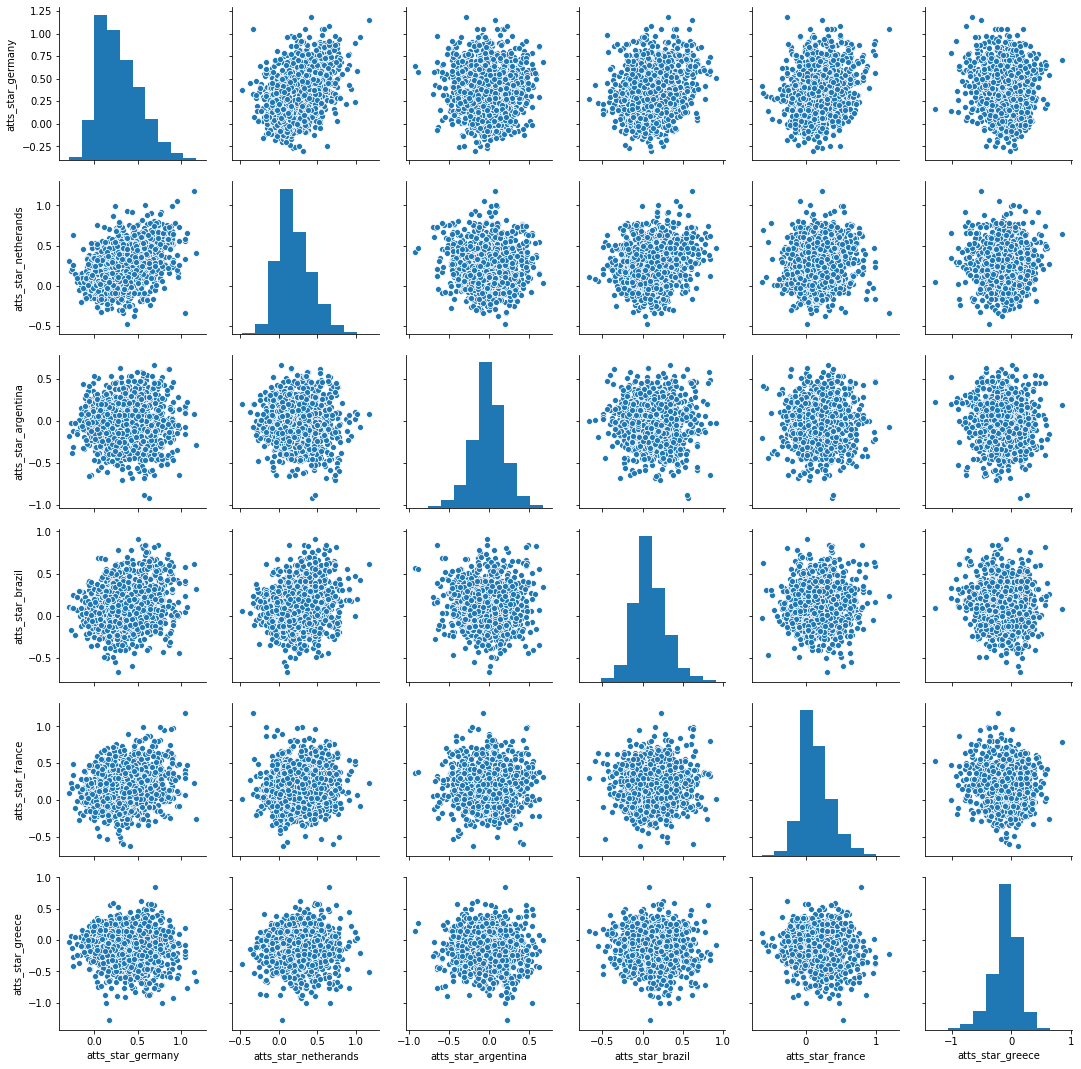

In [48]:
import seaborn as sns

cols = {
    'atts_star__12': 'atts_star_germany',
    'atts_star__25': 'atts_star_netherands',
    'atts_star__10': 'atts_star_argentina',
    'atts_star__0': 'atts_star_brazil',
    'atts_star__9': 'atts_star_france',
    'atts_star__26': 'atts_star_greece'
}

df_trace_att = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_att)

.. and defensive strengths:

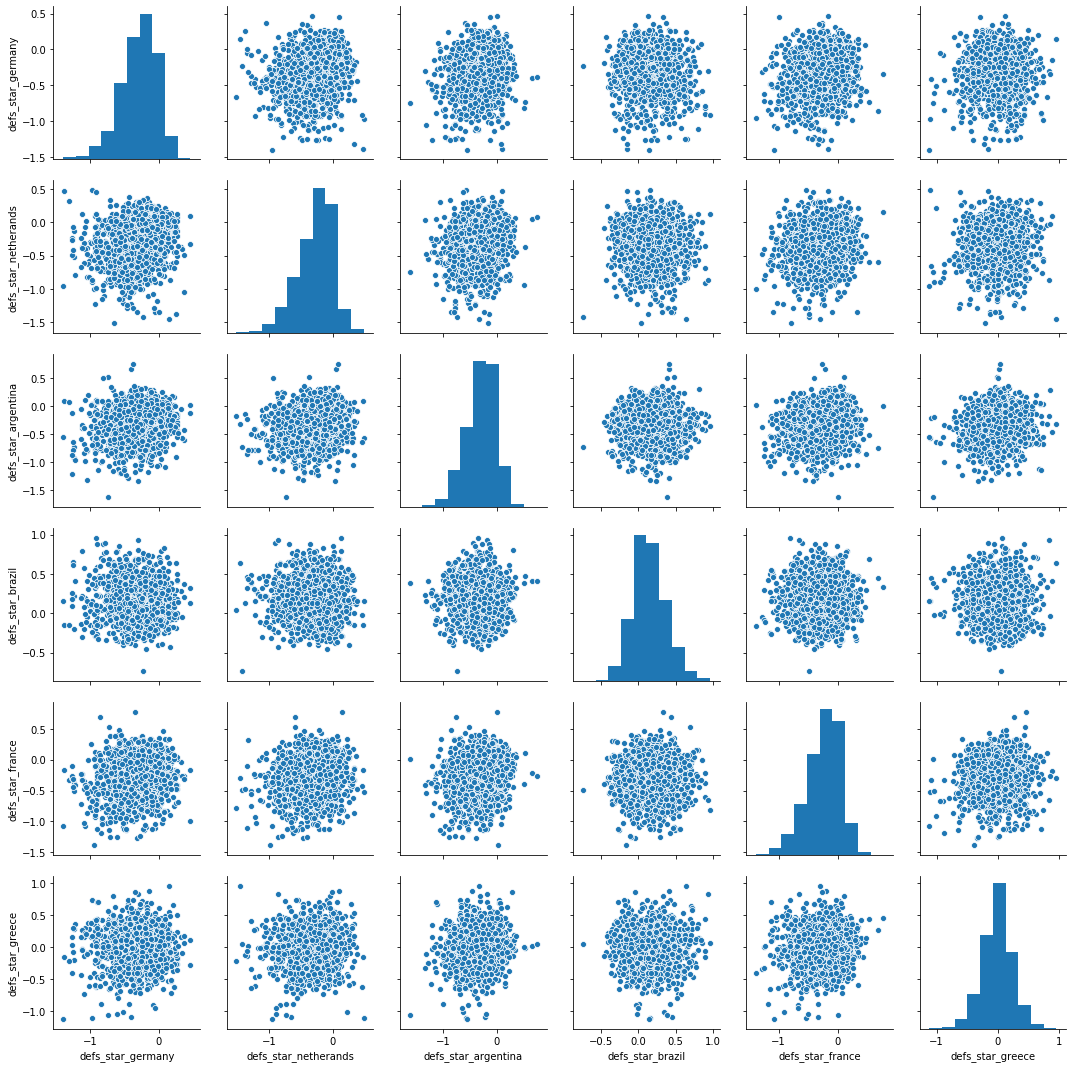

In [49]:
import seaborn as sns

cols = {
    'defs_star__12': 'defs_star_germany',
    'defs_star__25': 'defs_star_netherands',
    'defs_star__10': 'defs_star_argentina',
    'defs_star__0': 'defs_star_brazil',
    'defs_star__9': 'defs_star_france',
    'defs_star__26': 'defs_star_greece'
}

df_trace_def = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_def)

Both attack and defense covariates appear uncorrelated between teams, to me.

<div style="text-align: right; color: gray">10</div>

# Model's Statistical Power

This is a good example of a complex Sport Analytic Model, with a Poisson data likelihood.

We *quantified* the attacking and defensive strength of World Cup teams as parameters of a Bayesian model, together with credibility intervals, with data from World Cup Brazil 2014.

What's our independent variable here? Attack and defense based on score differentials, right? 

What's our covariate (dependent parameter, what we're modeling): How many points the team is going to score, right? 

So we used score differentials as a basis to predict... probable scores. Obviously, if you're a team that scores many goals and does not allow other team to score goals on you, you are going to do pretty well, everybody will tell you that.

So our model is not very **informative**. It would have been much more interesting to find out that specific features of a team matter more than others. It's pretty obvious that scoring will make a big difference on... scoring!

A correct model will use ***unrelated*** independent variables to model a variable of interest that is likely to be dependent.  But not so directly dependent that they are one and the same! 

So your job for your final project is to find a few uncorrelated variables to use as a Bayesian linear model for another variable you want to be able to predict. 

In baseball for example, you may use ERA and other player statistics to predict which team is going to win. There are many fantasy sports sites that keep score on many variables that you could use to build a sport-team bayesian model!

And now you have an example of how to proceed!